In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import einops
import pandas as pd

import json
import cv2
import os

import jax
import jax.numpy as jnp
import jax.nn as jnn

import json
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [36]:
# rbf kernel
def kernel(x,x2,a,l):
    diff = jnp.linalg.norm((x[None,...]-x2[:,None,:])/l[:,None,None],axis=-1)**2
    return a[:,None,None]**2*jnp.exp(-0.5*diff)

key = jax.random.PRNGKey(0)
n = 50
x,y = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))
xy = np.stack([x.flatten(),y.flatten()]).T

n2 = 50
x2,y2 = np.meshgrid(np.linspace(350/2048,1,n),np.linspace(0,1800/2048,n2))
xy2 = np.stack([x2.flatten(),y2.flatten()]).T

In [41]:
def gen(mec,fit,combined,xy2):
    alpha_g_locations = jnp.array(fit.filter(regex=f'alpha_{mec}_locations').values)
    rho_g_locations = jnp.array(einops.rearrange(fit.filter(regex=f'rho_{mec}_locations').values,'i (k j) -> i k j',
                            i=4000,j=2,k=alpha_g_locations.shape[1]))
    sigma = jnp.array(fit['sigma'].values)
    eta_g = jnp.array(fit.filter(regex=f'eta_{mec}').values)
    offset_g = jnp.array(fit.filter(regex=f'offset_{mec}_location').values)
    batch_size = 25
    data_xy = jnp.array(combined['x'])
    Gs = []
    for idx,(i,j) in enumerate(zip(combined['loc_ids_1'],combined['loc_ids_2'])):
        eta_pred = jnp.array(np.random.normal(0,1,(batch_size,xy.shape[0])))
        GG = []
        for sub in tqdm(range(0,4000,batch_size)):
            s1 = sub
            s2 = sub+batch_size
            xy_c = jnp.concatenate([data_xy[(i-1):j,:],xy2])
            eta_loc = eta_g[s1:s2,(i-1):j]
            eta = jnp.hstack([eta_loc,eta_pred])
            nn = xy_c.shape[0]
            L_K = jnp.linalg.cholesky(kernel(xy_c,xy_c,alpha_g_locations[s1:s2,idx],rho_g_locations[s1:s2,idx])+\
                                    jnp.eye(nn)[None,...]*(sigma[s1:s2,None,None]**2+1e-2)) # 1e-1
            if mec=='g':
                G = einops.rearrange(jnn.softplus(jnp.einsum('nij,nj->ni',L_K,eta)+offset_g[s1:s2,idx,None])[:,-(n2*n2):],'i (j k) -> i j k',j=n,k=n)
            else:
                G = einops.rearrange(jnp.arcsin(jnn.sigmoid(jnp.einsum('nij,nj->ni',L_K,eta)+offset_g[s1:s2,idx,None]))[:,-(n2*n2):],'i (j k) -> i j k',j=n,k=n)

            GG.append(np.array(G))

        GG = np.concatenate(GG)
        Gs.append(GG)
    return Gs

## Gradient 

In [ ]:
with open('data/processed/gradient.json','r') as f:
    combined = json.load(f)
fit = pd.read_csv('data/processed/gradient.csv')

ids = np.array(combined['location_identifier'])-1
loc_ids = np.array(combined['loc_repeat'])-1
xs = np.array(combined['x'])

Gs = gen('g',fit,combined,xy2)

In [ ]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
subfigs = fig.subfigures(1, 2,wspace=0.1,width_ratios=[1, 1])

ax = subfigs[0].subplots(2, 1, subplot_kw={"projection": "3d"})

ax[0].plot_surface(x2*2048*0.325,y2*2048*0.325,np.nanmedian(Gs[2],axis=0),cmap='jet',alpha=1.0)
ax[1].plot_surface(x2*2048*0.325,y2*2048*0.325,np.nanmedian(Gs[3],axis=0),cmap='jet',alpha=1.0)

for (a,alp) in zip(ax,['A','B']):
    a.view_init(azim=120, elev=30)
    a.set_xlabel(r'y [$\mu m$]')
    a.set_ylabel(r'x [$\mu m$]')

    a.text2D(0.02,0.9,alp,transform=a.transAxes,fontsize=20,clip_on=True)

m_point = 2048*0.325/2
ax2 = subfigs[1].subplots(2, 1)
for idx,(loc,a,b,alp) in enumerate(zip([2,3],ax2,ax,['C','D'])):
    med = np.mean(Gs[loc][...,24:25],axis=(0,2))
    low = np.percentile(Gs[loc][...,24:25],5,axis=(0,2))
    up = np.percentile(Gs[loc][...,24:25],95,axis=(0,2))
    x_range = np.linspace(0,2048*0.325,Gs[loc].shape[1])
    half = x_range.max()/2
    ll = np.where(x_range>half-70)[0][0]
    uu = np.where(x_range<half+70)[0][-1]
    a.plot(x_range,med,color='black')
    a.fill_between(x_range[:ll],low[:ll],up[:ll],alpha=0.2,color='crimson')
    a.fill_between(x_range[ll:uu],low[ll:uu],up[ll:uu],alpha=0.2,color='gray')
    a.fill_between(x_range[uu:],low[uu:],up[uu:],alpha=0.2,color='blue')

    x_coords = np.array(combined['x'])[np.where(loc_ids==loc)[0]]*2048*0.325
    closest = (np.abs(x_range[...,None] - x_coords[:,1][None,...])).argmin(axis=0)
    a.scatter(x_coords[:,1],med[closest],color='black',s=20,edgecolors=None,alpha=1.0)
    a.set_ylabel(r'$|G^*|$ [Pa]')
    a.spines[['right', 'top']].set_visible(False)
    a.text(0.02,0.85,alp,transform=a.transAxes,fontsize=20,clip_on=True)
ax2[1].set_xlabel(r'x [$\mu m$]')

plt.show()
fig.savefig('results/gradients.png',dpi=300,bbox_inches='tight')


## Example spatial maps

In [ ]:
with open('data/processed/sample.json','r') as f:
    combined = json.load(f)
fit = pd.read_csv('data/processed/sample.csv')

ids = np.array(combined['location_identifier'])-1
loc_ids = np.array(combined['loc_repeat'])-1
xs = np.array(combined['x'])

Gs = gen('g',fit,combined,xy)
Gs_phi = gen('phi',fit,combined,xy)

In [26]:
# (n locations, mcmc samples, x, y)
print(len(Gs),Gs[0].shape)

6 (4000, 50, 50)


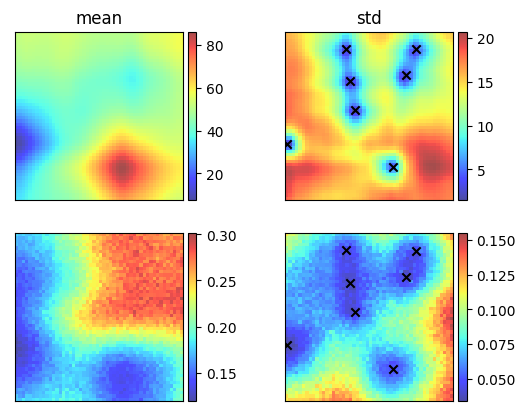

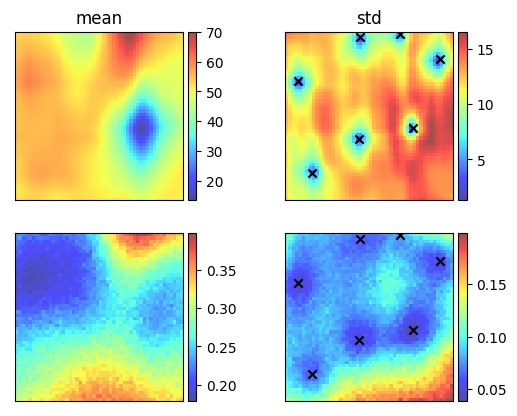

In [49]:
def bar(im,ax,fig):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')


# demonstrate with two locations
for loc in [0,2]:
    x_coords = xs[loc_ids==loc]
    fig,axes = plt.subplots(2,2)
    for ax,field in zip(axes,[Gs,Gs_phi]):
        im1 = ax[0].imshow(field[loc].mean(axis=0),cmap='jet',extent=(0,1,0,1),origin='lower',alpha=0.7)
        im2 = ax[1].imshow(field[loc].std(axis=0),cmap='jet',extent=(0,1,0,1),origin='lower',alpha=0.7)
        ax[1].scatter(*x_coords.T,color='black',marker='x')
        bar(im1,ax[0],fig)
        bar(im2,ax[1],fig)

    axes[0,0].set_ylabel(r'$|G^*|$')
    axes[1,0].set_ylabel(r'$\phi$')

    axes[0,0].set_title('mean')
    axes[0,1].set_title('std')

    for ax in axes.ravel():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)